In [1]:
import numpy as np
import pandas as pd
from IPython.display import display 

### Training and test set
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import Imputer, StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.base import clone
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from mlens.ensemble import SuperLearner
from mlens.visualization import corrmat
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[MLENS] backend: threading


In [2]:
df = pd.read_csv('./all/health-diagnostics-train.csv')
test = pd.read_csv('./all/health-diagnostics-test.csv')

df.replace('#NULL!',np.nan, inplace=True)
df.iloc[:, 0:(len(df.columns)-1)] = df.select_dtypes(include='object').apply(pd.to_numeric)
df.dropna(inplace=True)
test.replace('#NULL!',np.nan, inplace=True)
test = test.select_dtypes(include='object').apply(pd.to_numeric)
imp = Imputer(strategy='most_frequent')
imp.fit(test)
F_test = imp.transform(test)

In [3]:
X = df.drop('target',axis=1)
y=df['target']
F_test = pd.DataFrame(F_test, columns=X.columns)

In [4]:
seed = 23
np.random.seed(seed)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [6]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()

In [7]:
def get_models():
    lrc = LogisticRegression(C=10, class_weight='balanced', random_state=seed)
    
    sgd = SGDClassifier(loss='log', class_weight={0:0.01,1:0.99}, random_state=seed)
    
    rfc = RandomForestClassifier(
        n_estimators=25,
        max_depth=5,
        min_impurity_decrease=0.02,
        min_samples_leaf=0.003,
        min_samples_split=0.01,
        class_weight={0:0.01,1:0.99},
        max_features='auto',
        random_state=seed
    )
    
    nb = GaussianNB()
    
    models = {
        'lrc':lrc,
        'sgd':sgd,
        'rfc':rfc,
        'nb':nb
    }
    return models

def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((F_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(X, y)
        P.iloc[:, i] = m.predict_proba(F_test)[:,1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [8]:
models = get_models()
P = train_predict(models)
# score_models(P, y_test)

Fitting models.
lrc... done
sgd... done
rfc... 

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


done
nb... done
Done.



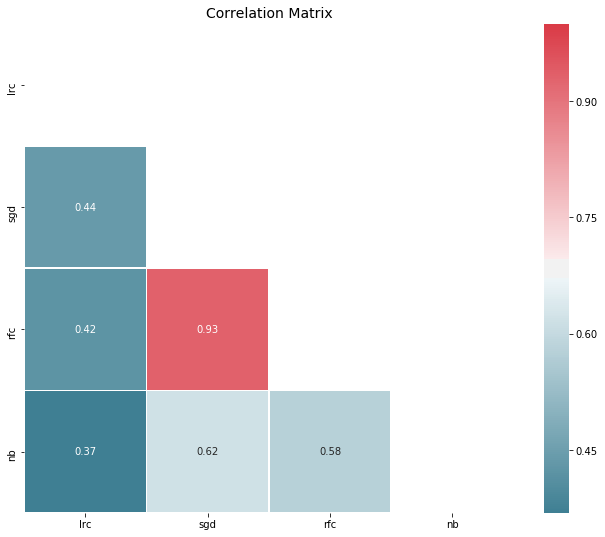

In [9]:
corrmat(P.apply(lambda pred: 1*(pred >= 0.5)).corr(), inflate=False)
plt.show()

In [10]:
# corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - y_test.values).corr(), inflate=False)
# plt.show()

In [11]:
# best_boundaries = {}
# for col in P.columns:
#     best_score = 0
#     for boundary in np.linspace(0.50,0.9, 40):
#         score = roc_auc_score(y_test, np.where(P[col]>boundary,1,0))
#         if score > best_score:
#             best_boundaries[col] = score

In [12]:
# boundaries = {'lrc': 0.85,
#               'sgd': 0.55,
#               'rfc': 0.5,
#               'nb' : 0.85}

In [13]:
boundaries = {'lrc': 0.5,
              'sgd': 0.5,
              'rfc': 0.5,
              'nb' : 0.5}

In [14]:
preds = {}
for col in P.columns:
    preds[col] = np.where(P[col]>boundaries[col],1,0)

In [15]:
preds = pd.DataFrame(preds)

In [16]:
# best_score = 0
# best_vote = 0
# for req_vote in range(1,3):
#     p = np.where(preds.sum(axis=1)>req_vote,1,0)
#     score = roc_auc_score(y_test, p)
#     if score> best_score:
#         best_vote = req_vote
#         best_score = score
# print(best_vote, best_score)

In [17]:
predictions = np.where(preds.sum(axis=1)>2,1,0)

In [19]:
np.sum(predictions)

38

In [ ]:
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['index','target']
predictions.to_csv('submissions.csv', index=False)

In [ ]:
predictions